In [1]:
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf 
from tensorflow.python.keras.models import Sequential 
from tensorflow.python.keras.layers import Input,Dense, Dropout, LSTM, SimpleRNN, RNN
from tensorflow.python.keras.models import Model, load_model
from tensorflow.python.keras.callbacks import ModelCheckpoint
from tensorflow.python.keras import regularizers

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import os
import glob


In [2]:
# 讀檔
# paths=['IP17','IP18','IP19','IP18','IP61','IP62','IP63','IP64']
# for path in paths:
#     all_filenames=[]
#     for root,dirs,files in os.walk('./'+path):
#         for file in files:
#             if file.endswith('.csv'):   #csv為結尾
#                 if os.path.join(root,file).rfind('NEW',0,100)!=-1:
#                     all_filenames.append(os.path.join(root,file))
# #             print(os.path.join(root,file))
#     combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames ],axis=0)
#     combined_csv.to_csv( path+".csv", index=False, encoding='utf-8-sig')

In [3]:
# 读取数据
d = pd.read_csv('IP61_1.csv')


In [4]:
def missingValuesInfo(df):
    total = df.isnull().sum().sort_values(ascending = False)
    percent = round(df.isnull().sum().sort_values(ascending = False)/len(df)*100, 2)
    temp = pd.concat([total, percent], axis = 1,keys= ['Total', 'Percent'])
    return temp.loc[(temp['Total'] > 0)]

In [5]:
d.describe()

,len,X_mean,Y_mean,Z_mean,X_abs_mean,Y_abs_mean,Z_abs_mean,X_median,Y_median,Z_median,...,Z_2400,Z_2410,Z_2420,Z_2430,Z_2440,Z_2450,Z_2460,Z_2470,Z_2480,Z_2490
count,4487.0,4.487000e+03,4.487000e+03,4.487000e+03,4487.000000,4487.000000,4487.000000,4487.000000,4487.000000,4487.000000,...,4487.000000,4487.000000,4487.000000,4487.000000,4487.000000,4487.000000,4487.000000,4487.000000,4487.000000,4487.000000
mean,30000.0,-7.685639e-19,-1.586834e-19,1.460813e-18,0.073533,0.228853,0.120356,-0.001289,0.000179,0.002757,...,0.000818,0.000993,0.001111,0.001009,0.000934,0.000771,0.000807,0.000677,0.000702,0.000661
std,0.0,4.854453e-17,7.580402e-17,1.560244e-16,0.009746,0.028070,0.012983,0.001449,0.001794,0.002468,...,0.000247,0.000383,0.000430,0.000352,0.000231,0.000195,0.000222,0.000175,0.000167,0.000184
min,30000.0,-2.569583e-16,-6.178650e-16,-9.716672e-16,0.052608,0.096485,0.072500,-0.006245,-0.006461,-0.018785,...,0.000354,0.000321,0.000325,0.000329,0.000356,0.000236,0.000320,0.000278,0.000315,0.000277
25%,30000.0,-3.002228e-17,-4.436359e-17,-1.190899e-16,0.066485,0.206012,0.113129,-0.002230,-0.001020,0.001358,...,0.000670,0.000722,0.000777,0.000762,0.000774,0.000638,0.000650,0.000556,0.000585,0.000532
50%,30000.0,-2.109424e-19,2.368476e-19,4.440892e-20,0.072592,0.229388,0.118393,-0.001021,0.000077,0.003073,...,0.000776,0.000897,0.001008,0.000953,0.000904,0.000741,0.000766,0.000655,0.000682,0.000631
75%,30000.0,2.801625e-17,4.499086e-17,1.174912e-16,0.079248,0.248745,0.124524,-0.000214,0.001227,0.004153,...,0.000911,0.001158,0.001378,0.001184,0.001059,0.000871,0.000925,0.000771,0.000793,0.000757
max,30000.0,2.199888e-16,5.215385e-16,1.195251e-15,0.114172,0.429474,0.246499,0.004773,0.012811,0.010614,...,0.005213,0.003105,0.003231,0.003023,0.002901,0.001866,0.002071,0.001749,0.001658,0.001923


In [6]:
X_fraud =d[(d['DateTime']> '2019-10-29 15:00:00.000000') 
           & (d['DateTime']< '2019-10-29 17:11:00.000000')]

In [7]:
X_fraud.head()

,DateTime,len,X_mean,Y_mean,Z_mean,X_abs_mean,Y_abs_mean,Z_abs_mean,X_median,Y_median,...,Z_2400,Z_2410,Z_2420,Z_2430,Z_2440,Z_2450,Z_2460,Z_2470,Z_2480,Z_2490
4288,2019-10-29 15:00:38.776000,30000.0,6.215861e-18,-1.092459e-17,-4.973799e-17,0.068165,0.225294,0.108602,-0.000188,0.002671,...,0.000706,0.000991,0.000889,0.000802,0.002064,0.000759,0.000941,0.000914,0.000410,0.000500
4289,2019-10-29 15:03:28.858000,30000.0,6.843045e-17,2.642678e-17,-9.062380e-17,0.068872,0.254964,0.124713,0.000860,0.005515,...,0.000948,0.000619,0.000642,0.000751,0.001794,0.000738,0.000785,0.000685,0.000770,0.000702
4290,2019-10-29 15:04:56.011000,30000.0,-4.389822e-17,-2.898469e-17,1.973088e-16,0.066571,0.238363,0.112964,0.000984,0.002741,...,0.000730,0.000729,0.000950,0.000613,0.001839,0.001086,0.001125,0.000727,0.000619,0.000526
4291,2019-10-29 15:06:22.197000,30000.0,-3.549429e-17,-2.033929e-17,1.485922e-16,0.069297,0.234845,0.114469,0.000618,0.002957,...,0.000783,0.001059,0.000674,0.000913,0.001624,0.000610,0.000601,0.000585,0.000976,0.000432
4292,2019-10-29 15:09:11.493000,30000.0,-4.234298e-17,4.070818e-17,-4.140392e-17,0.068338,0.239118,0.113441,0.000872,0.004397,...,0.000850,0.000633,0.000710,0.000852,0.002383,0.001124,0.000585,0.000719,0.000708,0.000514


In [8]:
missingValuesInfo(X_fraud)

,Total,Percent


In [9]:
X_fraud=X_fraud.ix[:,62:]

In [10]:
X_fraud.head()

,X_0,X_10,X_20,X_30,X_40,X_50,X_60,X_70,X_80,X_90,...,Z_2400,Z_2410,Z_2420,Z_2430,Z_2440,Z_2450,Z_2460,Z_2470,Z_2480,Z_2490
4288,0.000305,0.000268,0.001008,0.000650,0.017046,0.000967,0.000700,0.000830,0.001223,0.007822,...,0.000706,0.000991,0.000889,0.000802,0.002064,0.000759,0.000941,0.000914,0.000410,0.000500
4289,0.000405,0.000435,0.002494,0.000524,0.015189,0.001051,0.001627,0.000817,0.004459,0.000720,...,0.000948,0.000619,0.000642,0.000751,0.001794,0.000738,0.000785,0.000685,0.000770,0.000702
4290,0.000367,0.000474,0.007923,0.000413,0.011205,0.000752,0.000774,0.001008,0.001818,0.005669,...,0.000730,0.000729,0.000950,0.000613,0.001839,0.001086,0.001125,0.000727,0.000619,0.000526
4291,0.000284,0.000398,0.005043,0.000462,0.004642,0.000633,0.001098,0.001795,0.001955,0.007747,...,0.000783,0.001059,0.000674,0.000913,0.001624,0.000610,0.000601,0.000585,0.000976,0.000432
4292,0.000576,0.000412,0.010530,0.000323,0.010741,0.001779,0.001213,0.001241,0.003144,0.000758,...,0.000850,0.000633,0.000710,0.000852,0.002383,0.001124,0.000585,0.000719,0.000708,0.000514


In [11]:
num_feats = X_fraud.select_dtypes( exclude = [ 'object','bool' ] ).columns
X_fraud[num_feats] = StandardScaler().fit_transform(X_fraud[num_feats])

In [12]:
df1 = d[(d['DateTime']> '2019-10-19 00:00:00.000000') & (d['DateTime']< '2019-10-21 00:00:00.000000')]

In [13]:
df1.head()

,DateTime,len,X_mean,Y_mean,Z_mean,X_abs_mean,Y_abs_mean,Z_abs_mean,X_median,Y_median,...,Z_2400,Z_2410,Z_2420,Z_2430,Z_2440,Z_2450,Z_2460,Z_2470,Z_2480,Z_2490
0,2019-10-19 00:00:41.196000,30000.0,1.025892e-17,2.271239e-17,-1.994257e-16,0.070809,0.222951,0.122722,-0.003742,0.000976,...,0.001049,0.001428,0.000722,0.000605,0.000817,0.000632,0.000925,0.000538,0.000839,0.000561
1,2019-10-19 00:02:21.377000,30000.0,-5.197046e-17,-2.374489e-17,9.089026e-18,0.069527,0.221122,0.122203,-0.002982,0.004024,...,0.000861,0.002395,0.000668,0.001007,0.000859,0.000663,0.000879,0.000514,0.000631,0.000720
2,2019-10-19 00:03:59.559000,30000.0,-4.718818e-17,-7.810789e-17,-1.442402e-16,0.070873,0.217916,0.122405,-0.002362,0.002160,...,0.000467,0.001610,0.001110,0.000632,0.000655,0.000531,0.000638,0.000725,0.000856,0.000619
3,2019-10-19 00:05:41.768000,30000.0,9.330499e-18,5.719840e-17,-2.716198e-16,0.071863,0.228636,0.126643,-0.003526,0.000868,...,0.000784,0.001798,0.000641,0.000794,0.000873,0.000744,0.000743,0.000830,0.000611,0.000431
4,2019-10-19 00:07:19.990000,30000.0,-1.690500e-17,-7.423691e-18,1.765995e-17,0.068177,0.220427,0.121817,-0.001855,0.001063,...,0.000834,0.001684,0.000924,0.000389,0.001305,0.001012,0.000712,0.000783,0.000559,0.000617


In [14]:
df1=df1.ix[:,62:]

In [15]:
missingValuesInfo(df1)

,Total,Percent


In [16]:
df1.describe()

,X_0,X_10,X_20,X_30,X_40,X_50,X_60,X_70,X_80,X_90,...,Z_2400,Z_2410,Z_2420,Z_2430,Z_2440,Z_2450,Z_2460,Z_2470,Z_2480,Z_2490
count,941.000000,941.000000,941.000000,941.000000,941.000000,941.000000,941.000000,941.000000,941.000000,941.000000,...,941.000000,941.000000,941.000000,941.000000,941.000000,941.000000,941.000000,941.000000,941.000000,941.000000
mean,0.000453,0.000611,0.003961,0.000739,0.008393,0.001025,0.005661,0.004840,0.003546,0.006496,...,0.000816,0.001022,0.001200,0.000997,0.000921,0.000776,0.000803,0.000681,0.000707,0.000651
std,0.000147,0.000202,0.004097,0.000317,0.005085,0.000603,0.007000,0.007080,0.002761,0.006803,...,0.000233,0.000410,0.000467,0.000337,0.000232,0.000200,0.000220,0.000171,0.000161,0.000171
min,0.000094,0.000206,0.000343,0.000095,0.000477,0.000045,0.000251,0.000337,0.000540,0.000452,...,0.000354,0.000398,0.000446,0.000357,0.000356,0.000306,0.000350,0.000318,0.000362,0.000313
25%,0.000354,0.000477,0.001571,0.000532,0.004315,0.000686,0.001912,0.001344,0.001562,0.001697,...,0.000670,0.000733,0.000835,0.000763,0.000753,0.000638,0.000649,0.000560,0.000599,0.000531
50%,0.000441,0.000571,0.002899,0.000659,0.007762,0.000919,0.003478,0.002270,0.002786,0.003469,...,0.000775,0.000911,0.001107,0.000952,0.000886,0.000745,0.000760,0.000662,0.000686,0.000627
75%,0.000536,0.000694,0.005090,0.000858,0.011509,0.001215,0.005892,0.004497,0.004584,0.009347,...,0.000906,0.001215,0.001503,0.001156,0.001052,0.000873,0.000906,0.000778,0.000801,0.000734
max,0.001353,0.001785,0.052759,0.002076,0.026537,0.007125,0.050944,0.048573,0.020981,0.033726,...,0.002522,0.003105,0.003231,0.002874,0.002248,0.001866,0.001982,0.001579,0.001511,0.001897


In [17]:
num_feats = df1.select_dtypes( exclude = [ 'object','bool' ] ).columns
df1[num_feats] = StandardScaler().fit_transform(df1[num_feats])

In [18]:
df1.describe()

,X_0,X_10,X_20,X_30,X_40,X_50,X_60,X_70,X_80,X_90,...,Z_2400,Z_2410,Z_2420,Z_2430,Z_2440,Z_2450,Z_2460,Z_2470,Z_2480,Z_2490
count,9.410000e+02,9.410000e+02,9.410000e+02,9.410000e+02,9.410000e+02,9.410000e+02,9.410000e+02,9.410000e+02,9.410000e+02,9.410000e+02,...,9.410000e+02,9.410000e+02,9.410000e+02,9.410000e+02,9.410000e+02,9.410000e+02,9.410000e+02,9.410000e+02,9.410000e+02,9.410000e+02
mean,6.111536e-17,5.427233e-18,7.786899e-17,-1.569178e-17,1.824022e-16,5.144073e-17,5.191266e-17,-5.562913e-17,1.271860e-16,5.380039e-17,...,5.427233e-17,1.561509e-16,-2.245223e-16,-1.059490e-16,5.879109e-16,1.685982e-16,2.356127e-16,3.202067e-16,-2.692379e-16,-1.050052e-16
std,1.000532e+00,1.000532e+00,1.000532e+00,1.000532e+00,1.000532e+00,1.000532e+00,1.000532e+00,1.000532e+00,1.000532e+00,1.000532e+00,...,1.000532e+00,1.000532e+00,1.000532e+00,1.000532e+00,1.000532e+00,1.000532e+00,1.000532e+00,1.000532e+00,1.000532e+00,1.000532e+00
min,-2.439686e+00,-2.010272e+00,-8.832945e-01,-2.033114e+00,-1.557605e+00,-1.624815e+00,-7.732447e-01,-6.363635e-01,-1.089084e+00,-8.889415e-01,...,-1.981116e+00,-1.524085e+00,-1.614109e+00,-1.899474e+00,-2.433067e+00,-2.352422e+00,-2.058867e+00,-2.124279e+00,-2.143440e+00,-1.969213e+00
25%,-6.766520e-01,-6.611095e-01,-5.833732e-01,-6.530770e-01,-8.024387e-01,-5.611625e-01,-5.359234e-01,-4.941056e-01,-7.186393e-01,-7.058299e-01,...,-6.266921e-01,-7.048763e-01,-7.808057e-01,-6.933578e-01,-7.212843e-01,-6.885798e-01,-6.999324e-01,-7.094969e-01,-6.680926e-01,-6.987525e-01
50%,-8.208292e-02,-1.967500e-01,-2.592648e-01,-2.500403e-01,-1.241844e-01,-1.747262e-01,-3.120825e-01,-3.632523e-01,-2.754524e-01,-4.452400e-01,...,-1.767036e-01,-2.693908e-01,-1.975846e-01,-1.340615e-01,-1.483978e-01,-1.532723e-01,-1.949802e-01,-1.089512e-01,-1.281700e-01,-1.386220e-01
75%,5.612885e-01,4.160673e-01,2.758394e-01,3.768822e-01,6.131490e-01,3.150169e-01,3.299644e-02,-4.851990e-02,3.763559e-01,4.193311e-01,...,3.871327e-01,4.717145e-01,6.495095e-01,4.724005e-01,5.690812e-01,4.877941e-01,4.680349e-01,5.682346e-01,5.891663e-01,4.888905e-01
max,6.109673e+00,5.828949e+00,1.191576e+01,4.222590e+00,3.570325e+00,1.011782e+01,6.472333e+00,6.180436e+00,6.317814e+00,4.005050e+00,...,7.315231e+00,5.086175e+00,4.348497e+00,5.567756e+00,5.725703e+00,5.461600e+00,5.362094e+00,5.268669e+00,5.000819e+00,7.281342e+00


W1115 11:48:04.680746  6556 deprecation.py:506] From C:\Users\jovih\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Train on 752 samples, validate on 189 samples
Epoch 1/100
752/752 [==============================] - 1s 888us/sample - loss: 0.9720 - mean_absolute_error: 0.7001 - val_loss: 0.9234 - val_mean_absolute_error: 0.6646
Epoch 2/100
752/752 [==============================] - 0s 221us/sample - loss: 0.8802 - mean_absolute_error: 0.6540 - val_loss: 0.8520 - val_mean_absolute_error: 0.6271
Epoch 3/100
752/752 [==============================] - 0s 206us/sample - loss: 0.8219 - mean_absolute_error: 0.6235 - val_loss: 0.8164 - val_mean_absolute_error: 0.6107
Epoch 4/100
752/752 [==============================] - 0s 182us/sample - loss: 0.7926 - mean_absolute_error: 0.6083 - val_loss: 0.7979 - val_mean_absolute_error: 0.6014
Epoch 5/100
752/752 [==============================] - 0s 179us/sample - loss: 0.7761 - mean_absolute_error: 0.5995 - val_loss: 0.7858 - val_mean_absolute_error: 0.5953
Epoch 6/100
752/752 [==============================] - 0s 186us/sample - loss: 0.7639 - mean_absolute_error: 

Epoch 49/100
752/752 [==============================] - 0s 177us/sample - loss: 0.6780 - mean_absolute_error: 0.5540 - val_loss: 0.7056 - val_mean_absolute_error: 0.5584
Epoch 50/100
752/752 [==============================] - 0s 150us/sample - loss: 0.6775 - mean_absolute_error: 0.5538 - val_loss: 0.7056 - val_mean_absolute_error: 0.5582
Epoch 51/100
752/752 [==============================] - ETA: 0s - loss: 0.6686 - mean_absolute_error: 0.551 - 0s 170us/sample - loss: 0.6771 - mean_absolute_error: 0.5537 - val_loss: 0.7051 - val_mean_absolute_error: 0.5575
Epoch 52/100
752/752 [==============================] - 0s 170us/sample - loss: 0.6766 - mean_absolute_error: 0.5532 - val_loss: 0.7048 - val_mean_absolute_error: 0.5574
Epoch 53/100
752/752 [==============================] - 0s 166us/sample - loss: 0.6762 - mean_absolute_error: 0.5532 - val_loss: 0.7047 - val_mean_absolute_error: 0.5576
Epoch 54/100
752/752 [==============================] - 0s 172us/sample - loss: 0.6758 - mean_ab

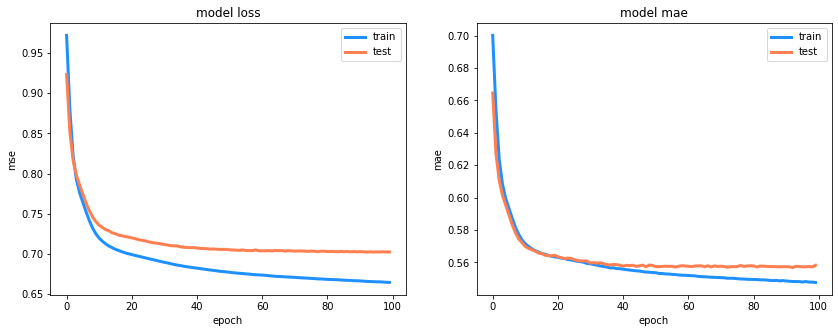

In [19]:
# 提取负样本，并且按照8:2切成训练集和测试集
# mask = (data['Class'] == 0)
X_train, X_test = train_test_split(df1, test_size=0.2, random_state=920)
# X_train = X_train.drop(['Class'], axis=1).values
# X_test = X_test.drop(['Class'], axis=1).values

# 提取所有正样本，作为测试集的一部分
# X_fraud = data[~mask].drop(['Class'], axis=1).values

# 设置Autoencoder的参数
# 隐藏层节点数分别为16，8，8，16
# epoch为50，batch size为32
input_dim = X_train.shape[1]
encoding_dim = 32
num_epoch = 100
batch_size =32

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-9))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="tanh")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='tanh')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['mae'])

# 模型保存为SofaSofa_model.h5，并开始训练模型
checkpointer = ModelCheckpoint(filepath="90_s_model.h5",
                               verbose=0,
                               save_best_only=True)
history = autoencoder.fit(X_train, X_train,
                          epochs=num_epoch,
                          batch_size=batch_size,
                          shuffle=True,
                          validation_data=(X_test, X_test),
                          verbose=1, 
                          callbacks=[checkpointer]).history

# 画出损失函数曲线
plt.figure(figsize=(14, 5))
plt.subplot(121)
plt.plot(history['loss'], c='dodgerblue', lw=3)
plt.plot(history['val_loss'], c='coral', lw=3)
plt.title('model loss')
plt.ylabel('mse'); plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.subplot(122)
plt.plot(history['mean_absolute_error'], c='dodgerblue', lw=3)
plt.plot(history['val_mean_absolute_error'], c='coral', lw=3)
plt.title('model mae')
plt.ylabel('mae'); plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');



In [20]:
# Y_train.iloc[0,0]

# arr_y =[]
# for i in range(len(Y_train)):
#     arr_y.append(Y_train.iloc[i,0])
# arr_y
# arr_y = np.array(arr_y)
# arr_y.shape

In [21]:
# 读取模型
autoencoder = load_model('90_s_model.h5')

# 利用训练好的autoencoder重建测试集
pred_test = autoencoder.predict(df1)
pred_fail = autoencoder.predict(X_fraud)


# 计算还原误差MSE和MAE
mse_test = np.mean(np.power(df1 - pred_test, 2), axis=1)
mse_fail = np.mean(np.power(X_fraud - pred_fail, 2), axis=1)

mae_test = np.mean(np.abs(df1 - pred_test), axis=1)
mae_fail = np.mean(np.abs(X_fraud - pred_fail), axis=1)



mse_df = pd.DataFrame()
mse_df['Class'] = [0] * len(mse_test) + [1] * len(mse_fail)
mse_df['MSE'] = np.hstack([mse_test, mse_fail])
mse_df['MAE'] = np.hstack([mse_test, mse_fail])
mse_df = mse_df.sample(frac=1).reset_index(drop=True)

mse_df=mse_df[(mse_df['MAE']<2)]

W1115 11:48:22.840939  6556 deprecation.py:506] From C:\Users\jovih\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1115 11:48:22.841934  6556 deprecation.py:506] From C:\Users\jovih\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


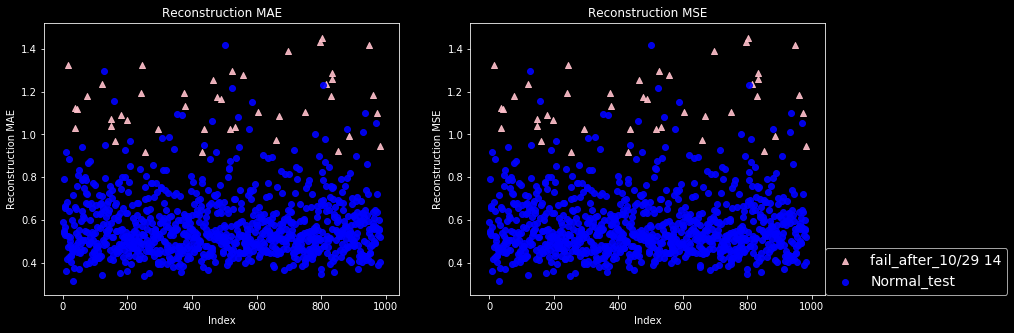

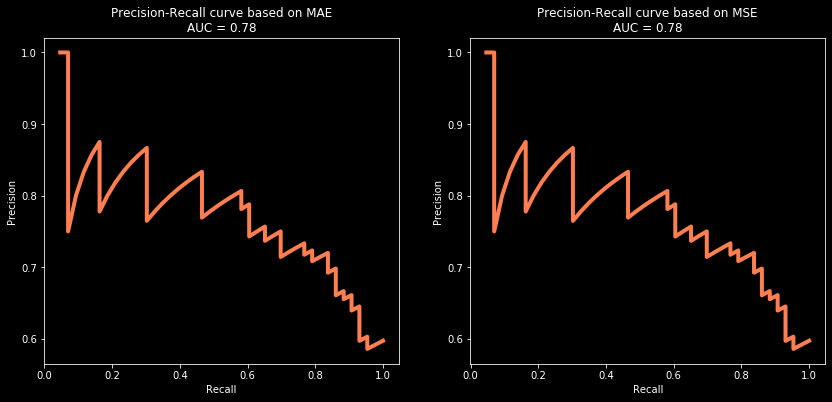

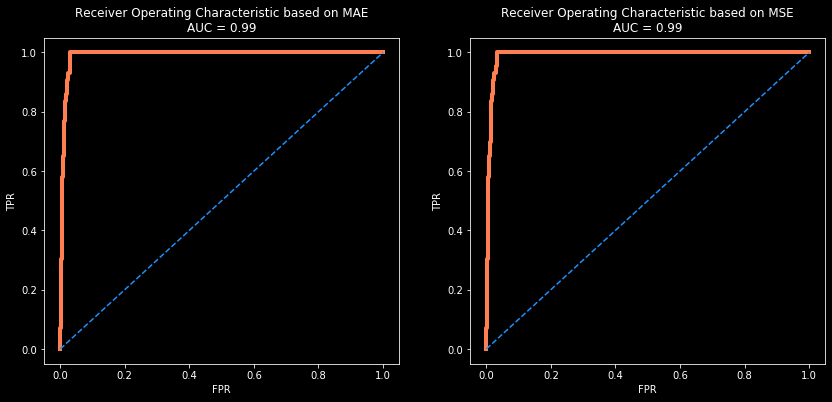

In [22]:
plt.style.use('dark_background')
# 分别画出测试集中正样本和负样本的还原误差MAE和MSE
markers = ['o', '^', 'x','+']
markers = ['o', '^','x','+']
colors = ['blue', 'pink','red','yellow']
labels = ['Normal_test', 'fail_after_10/29 14']

plt.figure(figsize=(14, 5))
plt.subplot(121)
for flag in [1, 0]:
    temp = mse_df[mse_df['Class'] == flag]
    plt.scatter(temp.index, 
                temp['MAE'],  
                alpha=0.9, 
                marker=markers[flag], 
                c=colors[flag], 
                label=labels[flag])
plt.title('Reconstruction MAE')
plt.ylabel('Reconstruction MAE'); plt.xlabel('Index')
plt.subplot(122)
for flag in [ 1, 0]:
    temp = mse_df[mse_df['Class'] == flag]
    plt.scatter(temp.index, 
                temp['MSE'],  
                alpha=0.9, 
                marker=markers[flag], 
                c=colors[flag], 
                label=labels[flag])
plt.legend(loc=[1,0], fontsize=14); plt.title('Reconstruction MSE')
plt.ylabel('Reconstruction MSE'); plt.xlabel('Index')
plt.show()
# 画出Precision-Recall曲线
plt.figure(figsize=(14, 6))
for i, metric in enumerate(['MAE', 'MSE']):
    plt.subplot(1, 2, i+1)
    precision, recall, th = precision_recall_curve(mse_df['Class'], mse_df[metric])
    pr_auc = auc(recall, precision)
    plt.title('Precision-Recall curve based on %s\nAUC = %0.2f'%(metric, pr_auc))
    plt.plot(recall[:-2], precision[:-2], c='coral', lw=4)
    plt.xlabel('Recall'); plt.ylabel('Precision')
plt.show()

# 画出ROC曲线
plt.figure(figsize=(14, 6))
for i, metric in enumerate(['MAE', 'MSE']):
    plt.subplot(1, 2, i+1)
    fpr, tpr, _ = roc_curve(mse_df['Class'], mse_df[metric])
    roc_auc = auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic based on %s\nAUC = %0.2f'%(metric, roc_auc))
    plt.plot(fpr, tpr, c='coral', lw=4)
    plt.plot([0,1],[0,1], c='dodgerblue', ls='--')
    plt.ylabel('TPR'); plt.xlabel('FPR')
plt.show()

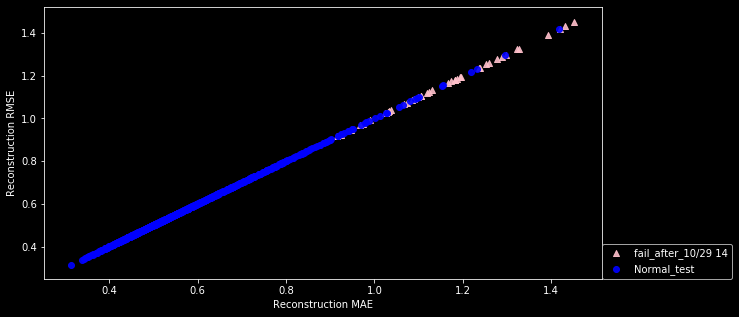

In [23]:
# 画出MSE、MAE散点图
markers = ['o', '^','x','+']
colors = ['blue', 'pink','red','yellow']
labels = ['Normal_test', 'fail_after_10/29 14']

plt.figure(figsize=(10, 5))
for flag in [1, 0]:
    temp = mse_df[mse_df['Class'] == flag]
    plt.scatter(temp['MAE'], 
                temp['MSE'],  
                alpha=0.9, 
                marker=markers[flag], 
                c=colors[flag], 
                label=labels[flag])
plt.legend(loc=[1, 0])
plt.ylabel('Reconstruction RMSE'); plt.xlabel('Reconstruction MAE')
plt.show()

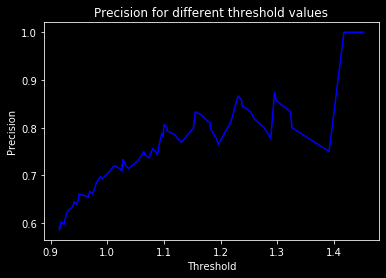

In [24]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

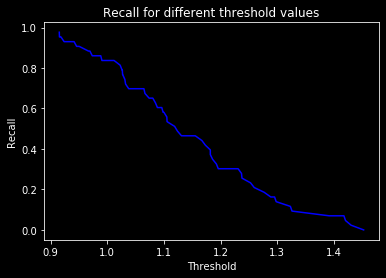

In [25]:
plt.plot(th, recall[1:], 'b', label='Threshold-recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Recall')
plt.show()

In [26]:
threshold = 1

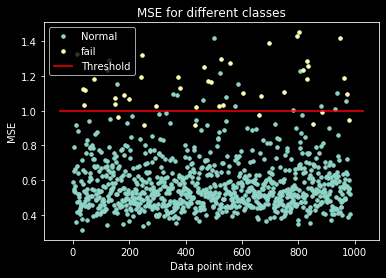

In [27]:
groups = mse_df.groupby('Class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.MSE, marker='o', ms=3.5, linestyle='',
            label= "fail" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("MSE for different classes")
plt.ylabel("MSE")
plt.xlabel("Data point index")
plt.show();

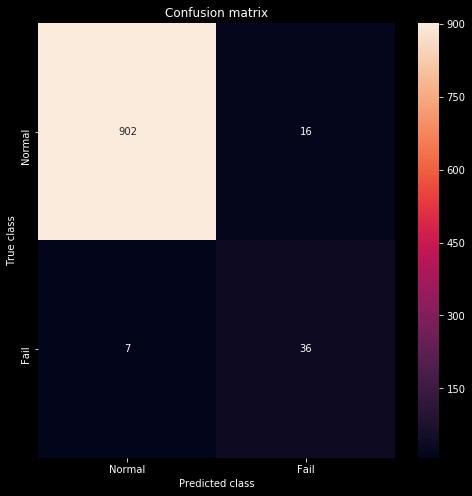

In [28]:
from sklearn.metrics import confusion_matrix,f1_score,accuracy_score
y_pred = [1 if e > threshold else 0 for e in mse_df.MSE.values]
conf_matrix = confusion_matrix(mse_df.Class, y_pred)
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, xticklabels=['Normal','Fail'], yticklabels=['Normal','Fail'], annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [29]:
print('acc score:',accuracy_score(mse_df.Class, y_pred))
print('f1 score:', f1_score(mse_df.Class, y_pred))

acc score: 0.9760665972944849
f1 score: 0.7578947368421053
